In [137]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Etape 5 : Interprétation et Visualisation

## Configuration des graphiques et préparation du DataFrame

In [138]:
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

csv_path = "data/final_cve_data.csv"
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Le fichier CSV n'a pas été trouvé à l'emplacement : {csv_path}.")
df = pd.read_csv(csv_path)
print(f"Total des vulnérabilités : {len(df)}")

# Explicitly convert the 'date' column to datetime, handling timezone
df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)
df['date'] = df['date'].dt.tz_localize(None)  # Remove timezone info if present

df.dropna(subset=['cvss_score', 'epss_score'], inplace=True)
df['cvss_score'] = df['cvss_score'].astype(float)
df['epss_score'] = df['epss_score'].astype(float)
df['base_severity'] = df['base_severity'].fillna("Unknown")

print(f"Nombre de vulnérabilités avec score CVSS et EPSS : {len(df)}")

Total des vulnérabilités : 1280
Nombre de vulnérabilités avec score CVSS et EPSS : 330


## Historigramme des scores CVSS

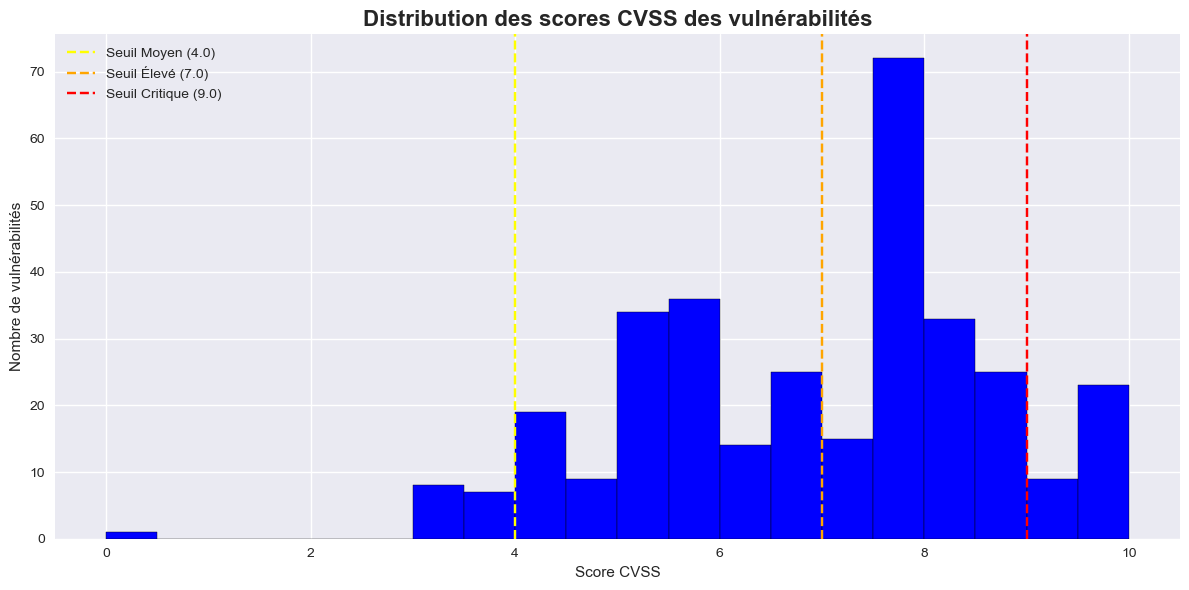

In [139]:
plt.figure(figsize=(12, 6))
plt.hist(df['cvss_score'], bins=20, color='blue', edgecolor='black')
plt.title("Distribution des scores CVSS des vulnérabilités", fontsize=16, fontweight='bold')
plt.xlabel("Score CVSS")
plt.ylabel("Nombre de vulnérabilités")
plt.grid(True)

plt.axvline(x=4.0, color='yellow', linestyle='--', label='Seuil Moyen (4.0)')
plt.axvline(x=7.0, color='orange', linestyle='--', label='Seuil Élevé (7.0)')
plt.axvline(x=9.0, color='red', linestyle='--', label='Seuil Critique (9.0)')
plt.legend()
plt.tight_layout()
plt.show()

## Historigramme des scores EPSS

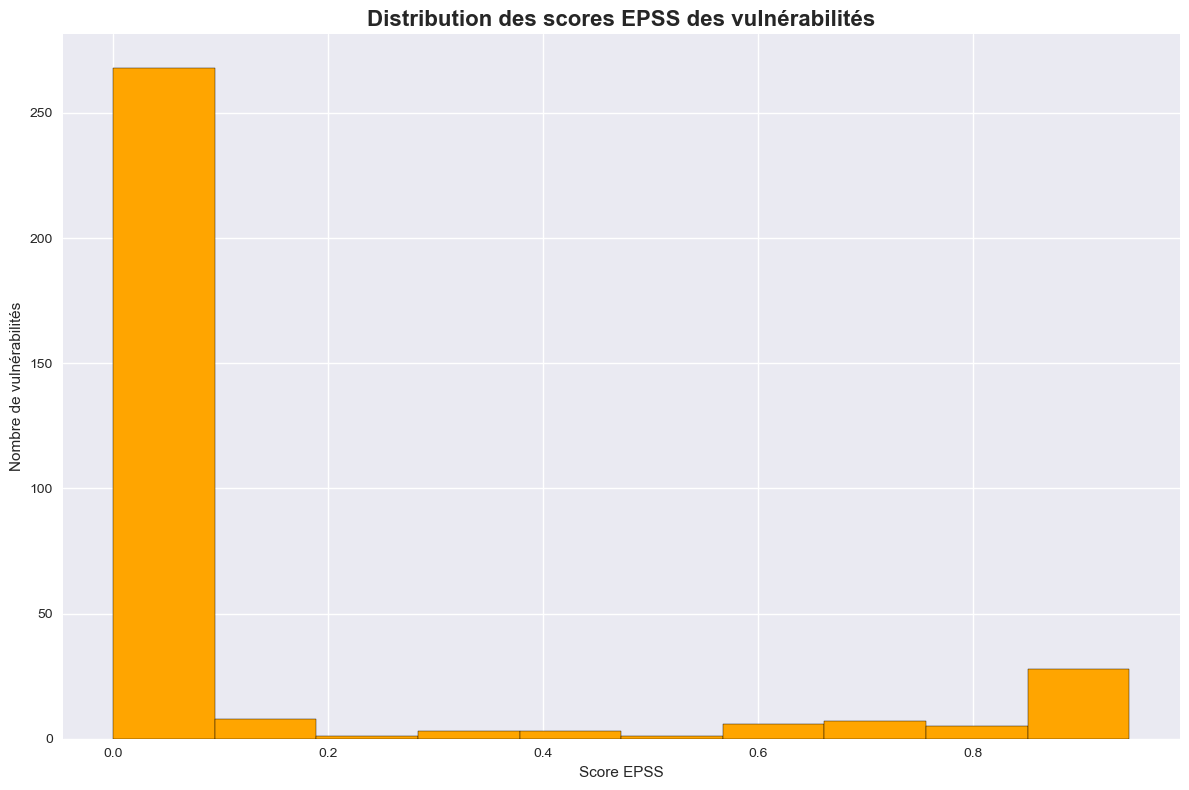

In [140]:
plt.figure(figsize=(12, 8))
plt.hist(df['epss_score'], bins=10, color='orange', edgecolor='black')
plt.title("Distribution des scores EPSS des vulnérabilités", fontsize=16, fontweight='bold')
plt.xlabel("Score EPSS")
plt.ylabel("Nombre de vulnérabilités")
plt.grid(True)
plt.tight_layout()
plt.show()

## Diagramme circulaire des types de vulnérabilités (CWE)

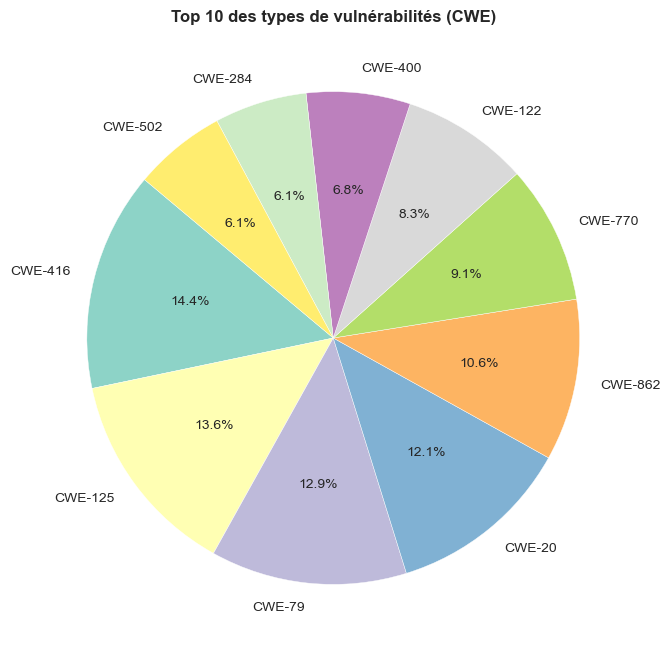

Répartition des CWE par rapport au dataset entier :
CWE-416: 19 (6.4%)
CWE-125: 18 (6.0%)
CWE-79: 17 (5.7%)
CWE-20: 16 (5.4%)
CWE-862: 14 (4.7%)
CWE-770: 12 (4.0%)
CWE-122: 11 (3.7%)
CWE-400: 9 (3.0%)
CWE-284: 8 (2.7%)
CWE-502: 8 (2.7%)


In [141]:
# Top 10 des codes CWE (hors "Non disponible")
top_cwe_codes = df[df['type_cwe'] != 'Non disponible']['type_cwe'].value_counts().nlargest(10)
labels = top_cwe_codes.index.tolist()
counts = top_cwe_codes.values

# Affichage du camembert
plt.figure(figsize=(8, 8))
colors = plt.cm.Set3(np.linspace(0, 1, len(counts)))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Top 10 des types de vulnérabilités (CWE)", fontweight='bold')
plt.show()

# Affichage de la répartition en texte
print("Répartition des CWE par rapport au dataset entier :")
total_valid = len(df[df['type_cwe'] != 'Non disponible'])
for cwe, count in zip(labels, counts):
    percentage = (count / total_valid) * 100
    print(f"{cwe}: {count} ({percentage:.1f}%)")

## Courbe des scores EPSS triés (priorisation)

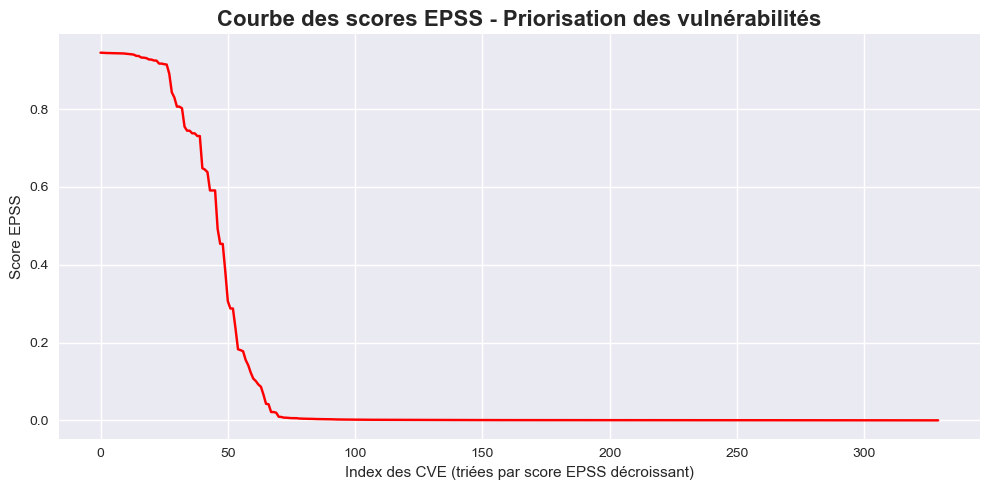

Score EPSS moyen: 0.1328
Score EPSS médian: 0.0006
Score EPSS maximum: 0.9448


In [142]:
plt.figure(figsize=(10, 5))
df_sorted_epss = df.sort_values(by='epss_score', ascending=False).reset_index()
plt.plot(df_sorted_epss.index, df_sorted_epss['epss_score'], color='red')
plt.title("Courbe des scores EPSS - Priorisation des vulnérabilités", fontsize=16, fontweight='bold')
plt.xlabel("Index des CVE (triées par score EPSS décroissant)")
plt.ylabel("Score EPSS")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate the mean, ignoring NaN values
print(f"Score EPSS moyen: {df['epss_score'].mean():.4f}")
print(f"Score EPSS médian: {df['epss_score'].median():.4f}")
print(f"Score EPSS maximum: {df['epss_score'].max():.4f}")

## Classement des produits/éditeurs les plus affectés

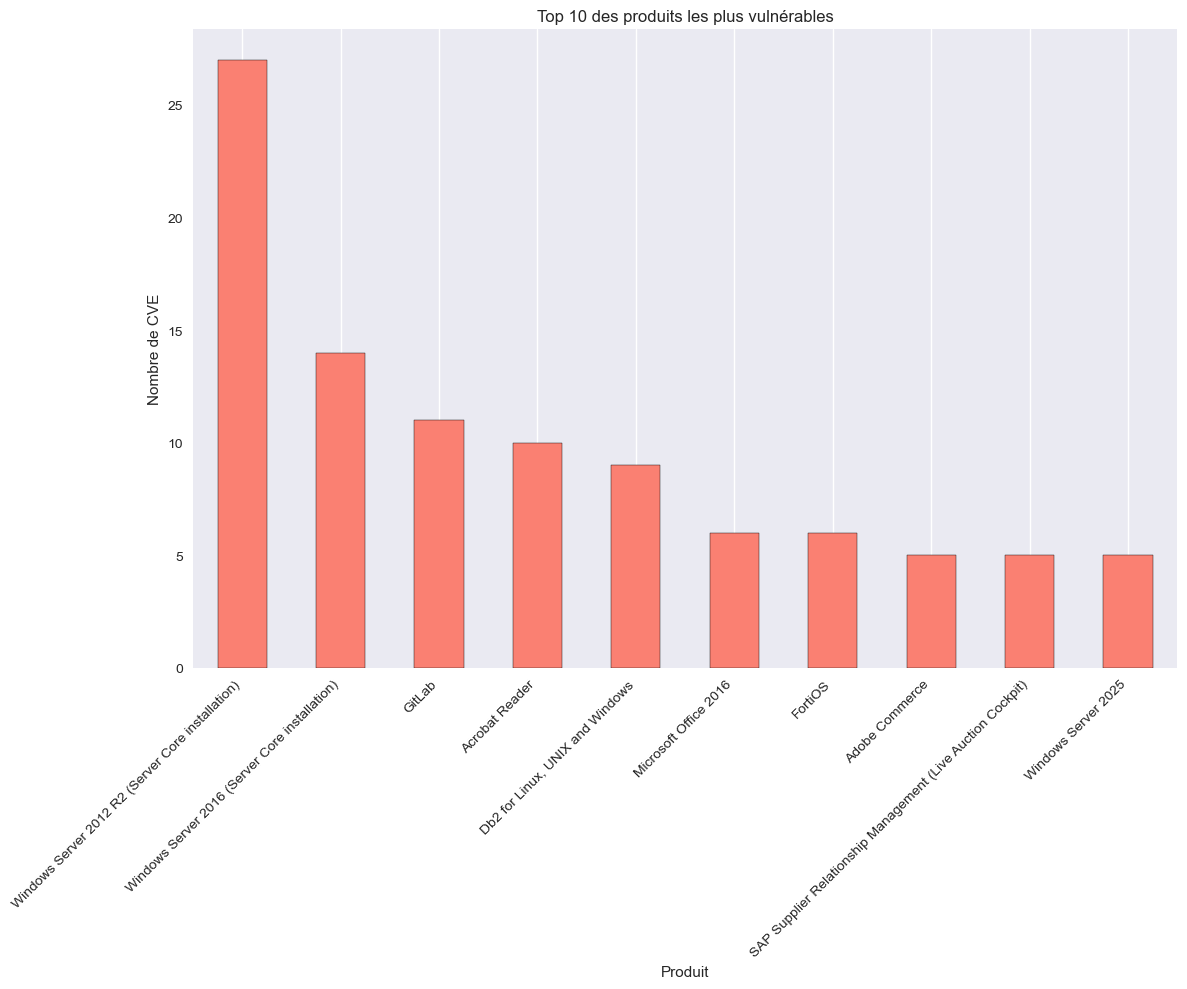

In [143]:
top_products = df['product'].value_counts().nlargest(10)
plt.figure(figsize=(12, 10))
top_products.plot(kind='bar', color='salmon', edgecolor='black')
plt.title("Top 10 des produits les plus vulnérables")
plt.xlabel("Produit")
plt.ylabel("Nombre de CVE")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Heatmap des corrélations entre CVSS et EPSS

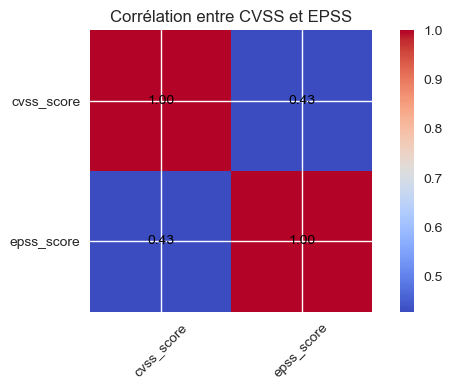

In [144]:
plt.figure(figsize=(6, 4))
corr = df[['cvss_score', 'epss_score']].corr()
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Corrélation entre CVSS et EPSS")
for i in range(len(corr)):
    for j in range(len(corr)):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha='center', va='center', color='black')
plt.tight_layout()
plt.show()

## Nuage de points entre score CVSS et score EPSS

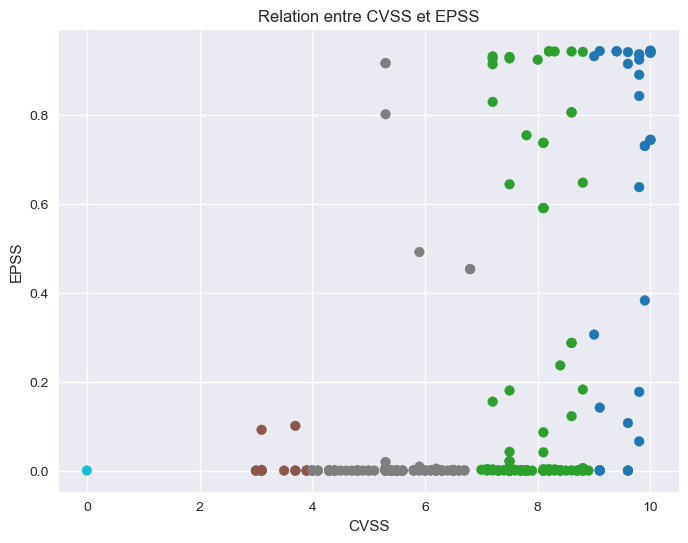

Coefficient de corrélation CVSS-EPSS: 0.4294


In [145]:
plt.figure(figsize=(8, 6))
colors = df['base_severity'].astype('category').cat.codes
plt.scatter(df['cvss_score'], df['epss_score'], c=colors, cmap='tab10')
plt.title("Relation entre CVSS et EPSS")
plt.xlabel("CVSS")
plt.ylabel("EPSS")
plt.grid(True)
plt.show()

# Calcul de la corrélation
correlation = df['cvss_score'].corr(df['epss_score'])
print(f"Coefficient de corrélation CVSS-EPSS: {correlation:.4f}")

## Courbe cumulative des vulnérabilités en fonction du temps

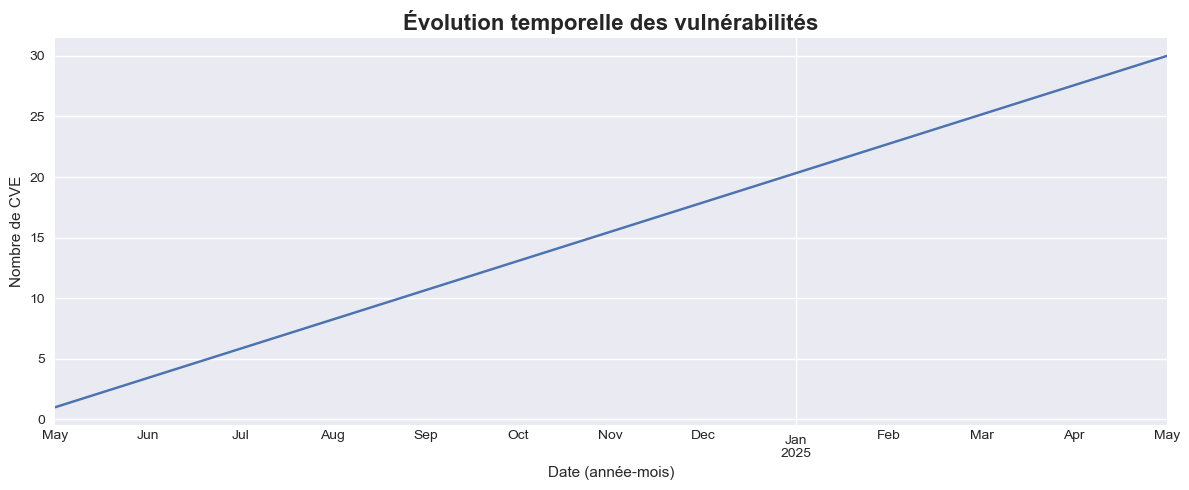

In [146]:
if pd.api.types.is_string_dtype(df['date']):
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
if pd.api.types.is_datetime64_any_dtype(df['date']):
    if hasattr(df['date'].dt, 'tz'):  # Only if timezone aware
        df['date'] = df['date'].dt.tz_localize(None)
df['year_month'] = df['date'].dt.to_period('M')
monthly_counts = df.groupby('year_month').size()
plt.figure(figsize=(12, 5))
monthly_counts.plot()
plt.title("Évolution temporelle des vulnérabilités", fontsize=16, fontweight='bold')
plt.xlabel("Date (année-mois)")
plt.ylabel("Nombre de CVE")
plt.grid(True)
plt.tight_layout()
plt.show()

## Boxplot des scores CVSS par éditeur (les 10 plus affectés)

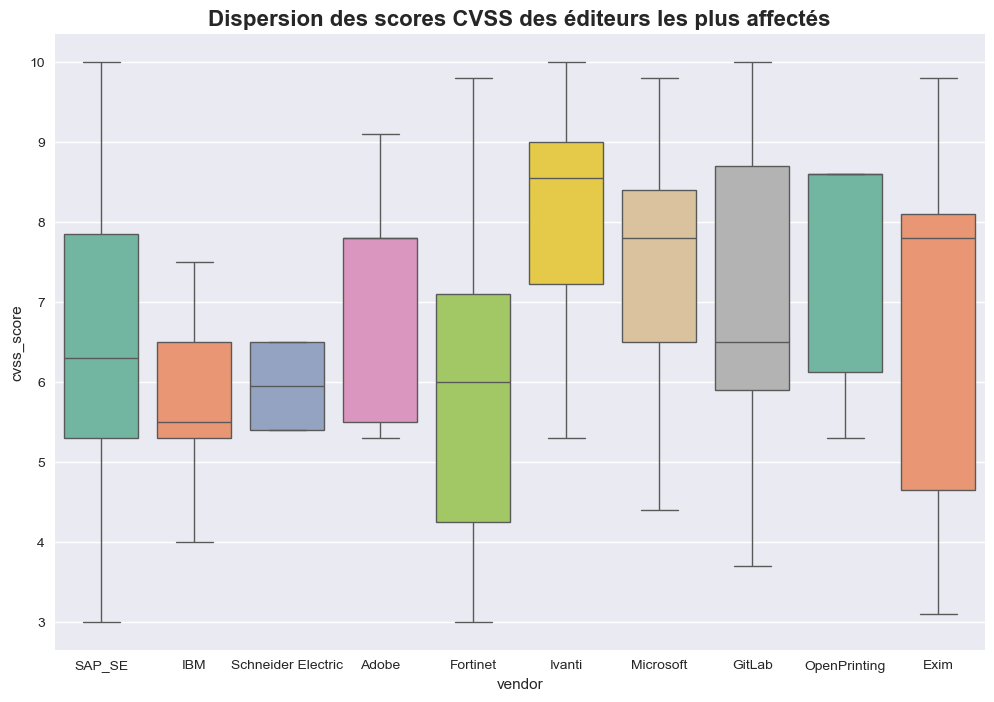

In [147]:
df_summary = df.groupby('vendor')['type_cwe'].count().reset_index(name='nb_vulnerabilites')
df_summary = df_summary.sort_values(by='nb_vulnerabilites', ascending=False)
top_df_summary = df_summary.head(10)
top_vendors = top_df_summary['vendor'].tolist()
df_top = df[df['vendor'].isin(top_vendors)]

CVSS_boxplot = sns.boxplot(data=df_top, x='vendor', y='cvss_score', palette='Set2', hue='vendor', legend=False, showfliers=False).set_title('Dispersion des scores CVSS des éditeurs les plus affectés', fontsize=16, fontweight='bold')

## Analyse spécifique d'un type de vulnérabilité (CWE-20 Improper Input Validation)

                        id                                              title  \
37    CERTFR-2025-AVI-0481  Multiples vulnérabilités dans les produits IBM...   
77    CERTFR-2025-AVI-0481  Multiples vulnérabilités dans les produits IBM...   
190   CERTFR-2025-AVI-0485  Multiples vulnérabilités dans les produits Sch...   
193   CERTFR-2025-AVI-0485  Multiples vulnérabilités dans les produits Sch...   
303   CERTFR-2025-AVI-0492  Multiples vulnérabilités dans les produits Sie...   
352   CERTFR-2025-AVI-0498  Multiples vulnérabilités dans Microsoft Office...   
410   CERTFR-2025-AVI-0501  Multiples vulnérabilités dans les produits Mic...   
1102  CERTFR-2025-AVI-0512  Multiples vulnérabilités dans les produits IBM...   
1103  CERTFR-2025-AVI-0512  Multiples vulnérabilités dans les produits IBM...   
1113  CERTFR-2025-AVI-0512  Multiples vulnérabilités dans les produits IBM...   
1193  CERTFR-2025-AVI-0512  Multiples vulnérabilités dans les produits IBM...   
1194  CERTFR-2025-AVI-0512  

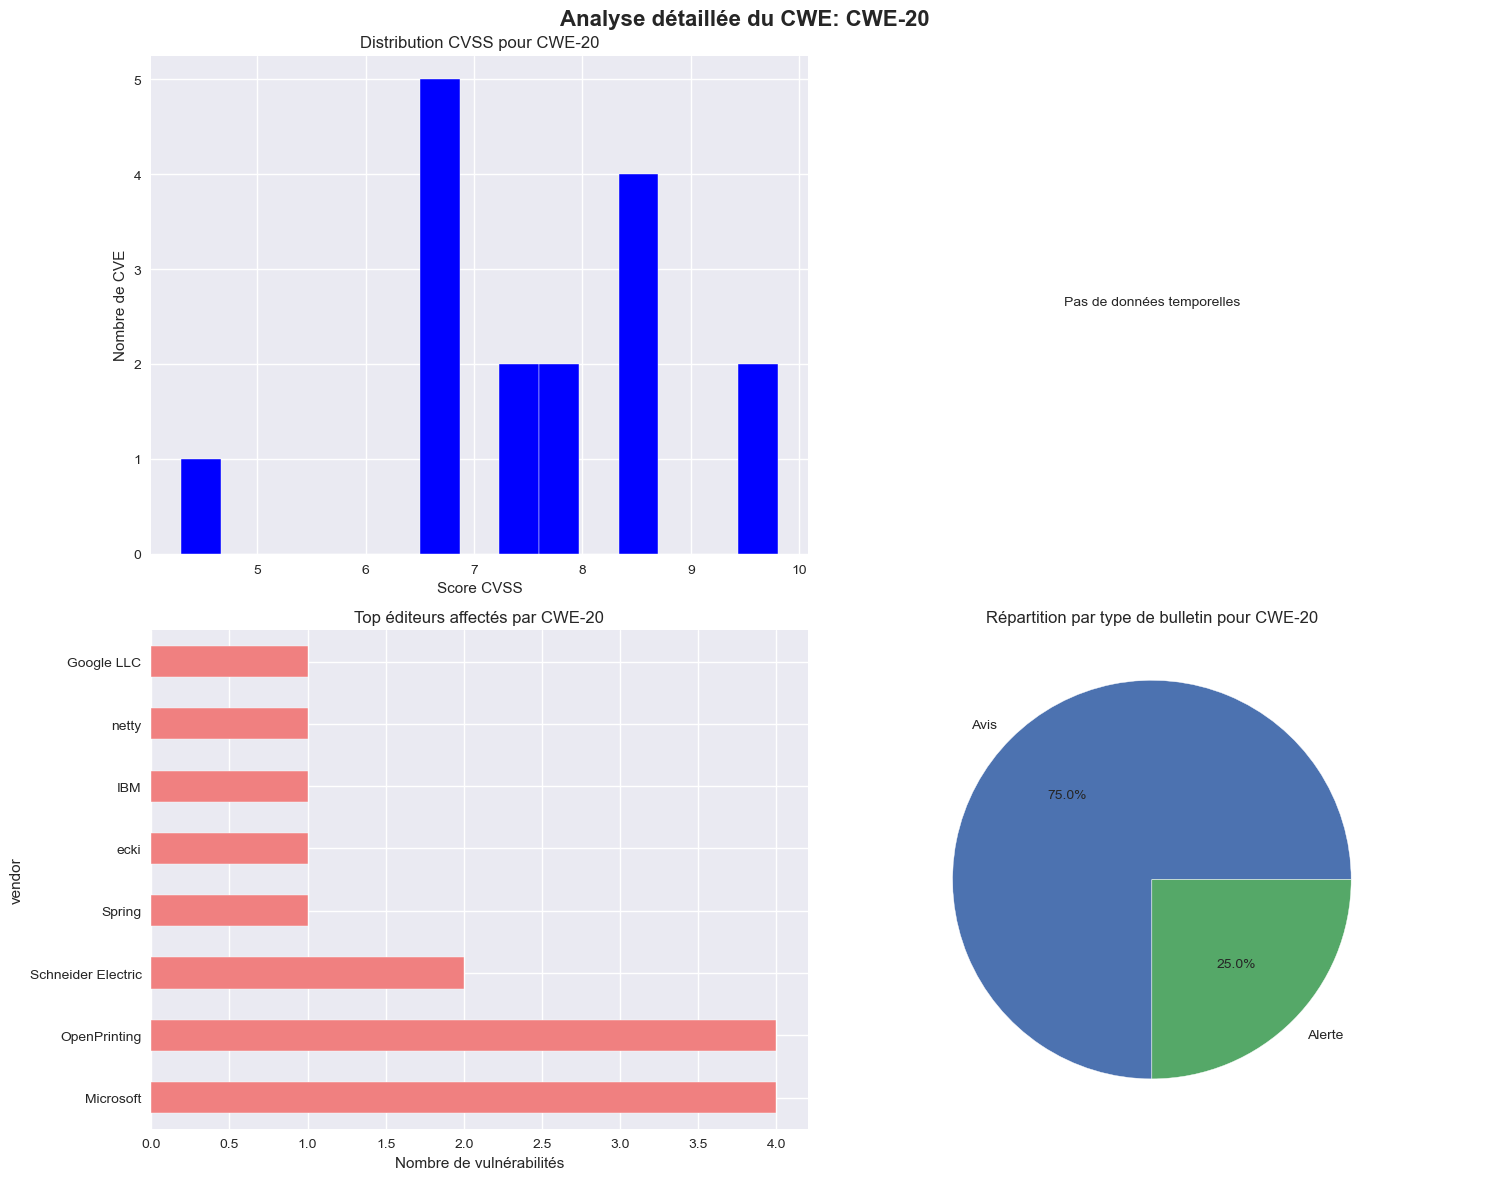

In [148]:
top_cwe = 'CWE-20'
cwe_specific = df[df['type_cwe'] == top_cwe].copy()
print(cwe_specific)

print(f"Analyse du CWE: {top_cwe}")
print(f"Nombre de vulnérabilités: {len(cwe_specific)}")
print("Description: CWE-20 Improper Input Validation")

if len(cwe_specific) > 10:  # Seulement si suffisamment de données
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Historigramme des scores CVSS
    ax1.hist(cwe_specific['cvss_score'].dropna(), bins=15, color='blue')
    ax1.set_title(f'Distribution CVSS pour {top_cwe}')
    ax1.set_xlabel('Score CVSS')
    ax1.set_ylabel('Nombre de CVE')

    # 2. Évolution temporelle
    if 'date' in cwe_specific.columns:
        cwe_temp = cwe_specific.dropna(subset=['date']).copy()
        print(len(cwe_temp))
        cwe_temp['date'] = pd.to_datetime(cwe_temp['date'], errors='coerce')
        if hasattr(cwe_temp['date'].dt, 'tz'):
            cwe_temp['date'] = cwe_temp['date'].dt.tz_localize(None)

        cwe_temp['year_month'] = cwe_temp['date'].dt.to_period('M')
        monthly = cwe_temp.groupby('year_month').size()

        if not monthly.empty:
            monthly.plot(marker='o', ax=ax2)
            ax2.set_title(f"Évolution temporelle pour {top_cwe}")
            ax2.set_xlabel("Date (mois)")
            ax2.set_ylabel("Nombre de vulnérabilités")
            ax2.grid(True)
        else:
            ax2.text(0.5, 0.5, "Pas de données temporelles", ha='center')
            ax2.axis('off')

    # 3. Editeurs les plus affectés
    cwe_vendors = cwe_specific['vendor'].dropna().astype(str)

    if not cwe_vendors.empty:
        vendor_counts = cwe_vendors.value_counts().head(10)
        vendor_counts.plot(kind='barh', ax=ax3, color='lightcoral')
        ax3.set_title(f'Top éditeurs affectés par {top_cwe}')
        ax3.set_xlabel('Nombre de vulnérabilités')
    else:
        ax3.text(0.5, 0.5, "Pas de données éditeur", ha='center')
        ax3.axis('off')

    # 4. Distribution par type de bulletin
    type_dist = cwe_specific['type'].value_counts()
    ax4.pie(type_dist.values, labels=type_dist.index, autopct='%1.1f%%')
    ax4.set_title(f'Répartition par type de bulletin pour {top_cwe}')

    plt.suptitle(f'Analyse détaillée du CWE: {top_cwe}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

## Versions les plus fréquemment touchées des produits concernés

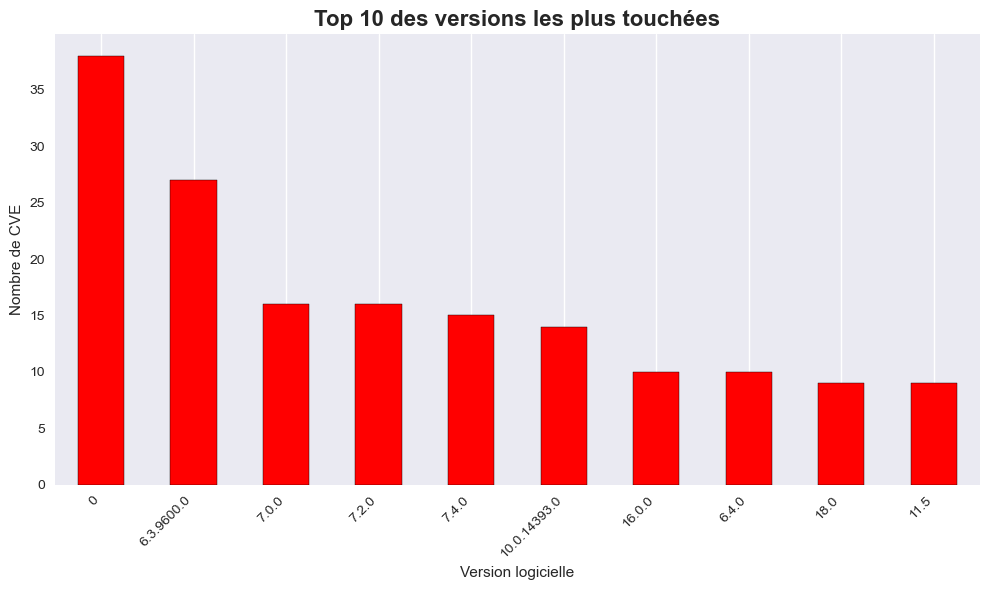

In [149]:
version_counts = df['versions'].dropna().str.split(', ').explode().value_counts().nlargest(10)
plt.figure(figsize=(10, 6))
version_counts.plot(kind='bar', color='red', edgecolor='black')
plt.title("Top 10 des versions les plus touchées", fontsize=16, fontweight='bold')
plt.xlabel("Version logicielle")
plt.ylabel("Nombre de CVE")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Nombre de vulnérabilités par éditeur et type de bulletin (avis ou alerte)

<Figure size 1200x1000 with 0 Axes>

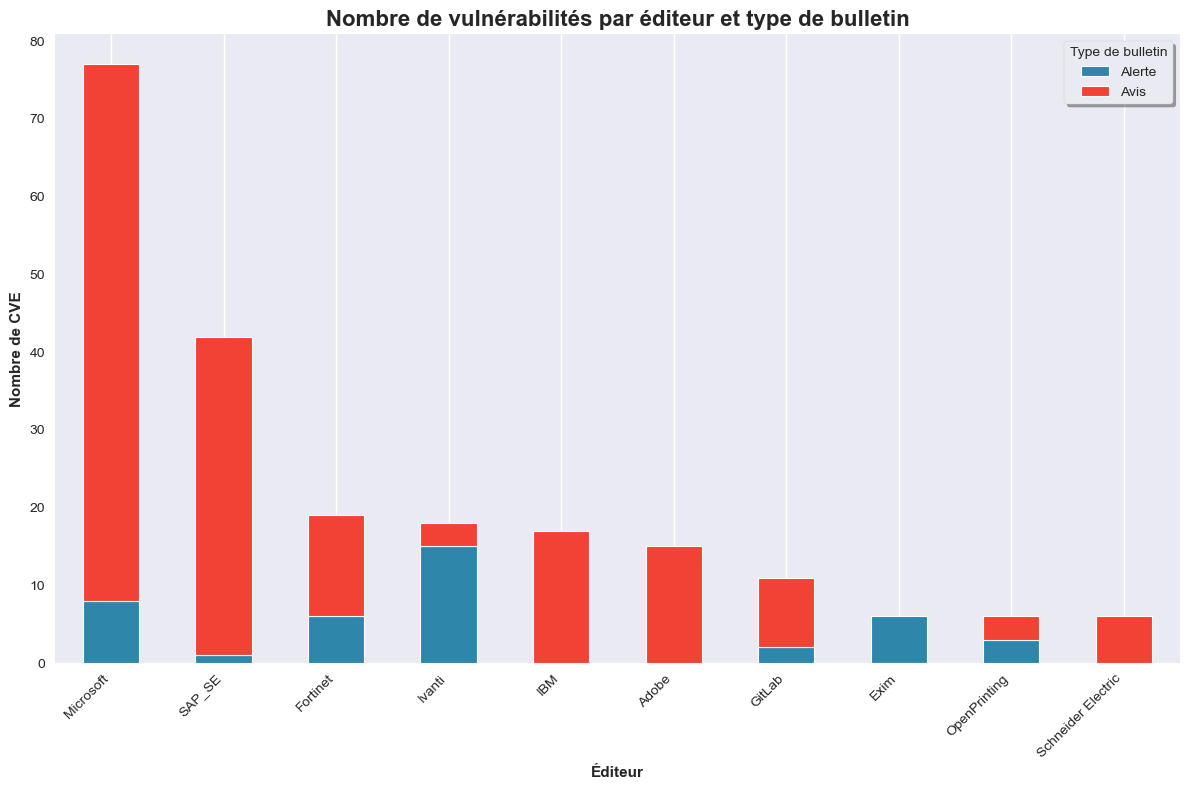

In [150]:
pivot = pd.pivot_table(df, values='cve_id', index='vendor', columns='type', aggfunc='count', fill_value=0)
top_vendors = pivot.sum(axis=1).nlargest(10).index

plt.figure(figsize=(12, 10))
pivot_subset = pivot.loc[top_vendors]

colors = ['#2E86AB', '#F24236']  # Blue and Red for better contrast
pivot_subset.plot(kind='bar', stacked=True, color=colors, edgecolor='white', linewidth=0.8)

plt.title("Nombre de vulnérabilités par éditeur et type de bulletin", fontsize=16, fontweight='bold')
plt.xlabel("Éditeur", fontweight='bold')
plt.ylabel("Nombre de CVE", fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Type de bulletin', frameon=True, fancybox=True, shadow=True)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Etape 6 : Génération d'Alertes et Notifications Email
Des alertes personnalisées sont générées lorsque des vulnérabilités critiques affectent
des logiciels spécifiques. Des notifications email sont envoyées aux abonnés.

**Mail destinataire :**\
    mail : to.aiciDS5@gmail.com\
    mdp : Aici@2004\

**Mail envoyeur :**\
    mail : from.aiciDS5@gmail.com\
    mdp : Aici@2004\
    mdp d'application : pmfakazcgvxwpkrq\

In [151]:
import smtplib
from email.mime.text import MIMEText

# Paramètres de configuration
FROM_EMAIL = "from.aiciDS5@gmail.com"
APP_PASSWORD = "pmfakazcgvxwpkrq " # Aici@2004
TO_EMAIL = "to.aiciDS5@gmail.com"

def send_email(to_email, subject, body):
    msg = MIMEText(body)
    msg['From'] = FROM_EMAIL
    msg['To'] = to_email
    msg['Subject'] = subject

    try:
        server = smtplib.SMTP("smtp.gmail.com", 587)
        server.starttls()
        server.login(FROM_EMAIL, APP_PASSWORD)
        server.sendmail(FROM_EMAIL, to_email, msg.as_string())
        server.quit()
        print(f"Email envoyé à {to_email}")
    except Exception as e:
        print(f"Erreur lors de l'envoi de l'email : {e}")


def check_critical_vulnerabilities(csv_path):
    df = pd.read_csv(csv_path)
    df = df.dropna(subset=["cvss_score", "epss_score"])
    df["cvss_score"] = df["cvss_score"].astype(float)
    df["epss_score"] = df["epss_score"].astype(float)

    # Seuils d’alerte
    critical = df[(df["cvss_score"] >= 9) | (df["epss_score"] >= 0.9)]

    for _, row in critical.iterrows():
        subject = f"ALERTE CVE CRITIQUE : {row['cve_id']}"
        body = (
            f"Titre : {row['title']}\n"
            f"Date : {row['date']}\n"
            f"CVE : {row['cve_id']}\n"
            f"Score CVSS : {row['cvss_score']}\n"
            f"Score EPSS : {row['epss_score']}\n"
            f"Produit : {row['product']}\n"
            f"Éditeur : {row['vendor']}\n"
            f"\nLien : {row['link']}\n"
            f"\nDescription :\n{row['description']}\n"
        )
        send_email(TO_EMAIL, subject, body)

In [152]:
check_critical_vulnerabilities("data/final_cve_data.csv")

Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gmail.com
Email envoyé à to.aiciDS5@gm

# Etape 7 : Modèles de Machine Learning

## Préparation des données et Normalisation

In [154]:
# Créer la colonne cible contenant la classe de la vulnérabilité : 1 si EPSS >= 0.7 (risque d'exploitation important), 0 sinon
df['epss_high_risk'] = (df['epss_score'] >= 0.7).astype(int)

# Nombre de vulnérabilités par classe
print(df['epss_high_risk'].value_counts(), "\n")

# Nettoyage des données
ml_df = df.dropna(subset=['cvss_score', 'epss_score', 'base_severity']) # Supprimer les lignes avec des valeurs manquantes dans les features critiques
print(f"Données après nettoyage: {len(ml_df)} lignes")

# Encodage de la sévérité en valeur numérique : (faible, moyenne, élevée, critique) -> (0, 1, 2, 3)
severity_encoder = LabelEncoder()
ml_df['severity_encoded'] = severity_encoder.fit_transform(ml_df['base_severity'])

# Préparation des features (CVSS et sévérité) et des labels (classe 0 ou 1)
features = ml_df[['cvss_score', 'severity_encoded']].copy() # On prédit le EPSS à partir du score CVSS et de la sévérité encodée
labels = ml_df['epss_high_risk'] # La valeur cible (que l'on cherche à prédire) est le risque EPSS élevé ou non
print(f"Features shape: {features.shape}") # Dimensions de la matrice features
print(f"\nFeatures statistiques:")
print(features.describe(), "\n") # Statistiques de la matrice features (moyenne, médiane, écart-type...)
print(features.head())

print(f"\nTarget shape: {labels.shape}")
print(f"\nTarget statistiques:")
print(labels.describe(), "\n")
print(labels.head())

# Vérifier qu'il reste suffisamment de données
if len(ml_df) < 10:
    print("\nPas assez de données pour le machine learning!")
else:
    print("\nDonnées suffisantes pour le machine learning")


# Normalisation des features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
print(f"\nFeatures normalisées shape: {X_scaled.shape}")
print(f"Moyennes après normalisation: {X_scaled.mean(axis=0)}")
print(f"Écarts-types après normalisation: {X_scaled.std(axis=0)}")

epss_high_risk
0    290
1     40
Name: count, dtype: int64 

Données après nettoyage: 330 lignes
Features shape: (330, 2)

Features statistiques:
       cvss_score  severity_encoded
count  330.000000        330.000000
mean     6.853333          1.787879
std      1.742828          1.101466
min      0.000000          0.000000
25%      5.500000          1.000000
50%      7.300000          1.000000
75%      8.100000          3.000000
max     10.000000          4.000000 

   cvss_score  severity_encoded
0         3.1                 2
1         4.1                 3
2         6.4                 3
3         6.3                 3
4         3.1                 2

Target shape: (330,)

Target statistiques:
count    330.000000
mean       0.121212
std        0.326869
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: epss_high_risk, dtype: float64 

0    0
1    0
2    0
3    0
4    0
Name: epss_high_risk, dtype: int64

Données suffisantes po

## Modèle supervisé 1 : Random Forest pour prédire les EPSS élevés (>= 0.7)
Objectif : prédire si une vulnérabilité a un risque d'exploitation important à partir de son score CVSS

In [155]:
# Division train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2, random_state=42, stratify=labels)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluation
print(f"\nScore d'accuracy: {clf.score(X_test, y_test):.3f}")
print("\nRapport de classification (Prédiction EPSS élevé):\n")
print(classification_report(y_test, y_pred))
print("\nMatrice de confusion:")
print(confusion_matrix(y_test, y_pred))

""" Raisons :
1. Déséquilibre entre les classes : classe 0 = 87% et classe 1 = 12%
2. Le lien entre score CVSS et score EPSS est faible
3. Manque de données contextuelles reliées à la probabilité d'exploitation d'une vulnérabilité
"""

# Explication pour le taux de précision de 50% sur la classe 1
print("\n", ml_df['epss_high_risk'].value_counts(normalize=True))


Score d'accuracy: 0.879

Rapport de classification (Prédiction EPSS élevé):

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        58
           1       0.50      0.50      0.50         8

    accuracy                           0.88        66
   macro avg       0.72      0.72      0.72        66
weighted avg       0.88      0.88      0.88        66


Matrice de confusion:
[[54  4]
 [ 4  4]]

 epss_high_risk
0    0.878788
1    0.121212
Name: proportion, dtype: float64


# Modèle supervisé 2 : Random Forest pour prédire le type de bulletin
Objectif : prédire le type de bulletin ('type') à partir des scores CVSS, EPSS et du type de vulnérabilité

In [156]:
ml_df = df.dropna(subset=['cvss_score', 'epss_score', 'type_cwe', 'type'])

# Encodage de la variable cible ('type' = Avis ou Alerte)
type_encoder = LabelEncoder()
ml_df['type_encoded'] = type_encoder.fit_transform(ml_df['type'])

# Encodage de 'type_cwe'
cwe_encoder = LabelEncoder()
ml_df['cwe_encoded'] = cwe_encoder.fit_transform(ml_df['type_cwe'])

# Features : CVSS + EPSS + CWE encodé
features = ml_df[['cvss_score', 'epss_score', 'cwe_encoded']]
labels = ml_df['type_encoded']

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Random Forest Classifier
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2, random_state=42, stratify=labels)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Rapport de classification (Prédiction type de bulletin):")
print(classification_report(y_test, y_pred, target_names=type_encoder.classes_))
print("Matrice de confusion:")
print(confusion_matrix(y_test, y_pred))

Rapport de classification (Prédiction type de bulletin):
              precision    recall  f1-score   support

      Alerte       0.67      0.73      0.70        11
        Avis       0.94      0.93      0.94        55

    accuracy                           0.89        66
   macro avg       0.81      0.83      0.82        66
weighted avg       0.90      0.89      0.90        66

Matrice de confusion:
[[ 8  3]
 [ 4 51]]


### Visualisation de la matrice de confusion

<Figure size 600x500 with 0 Axes>

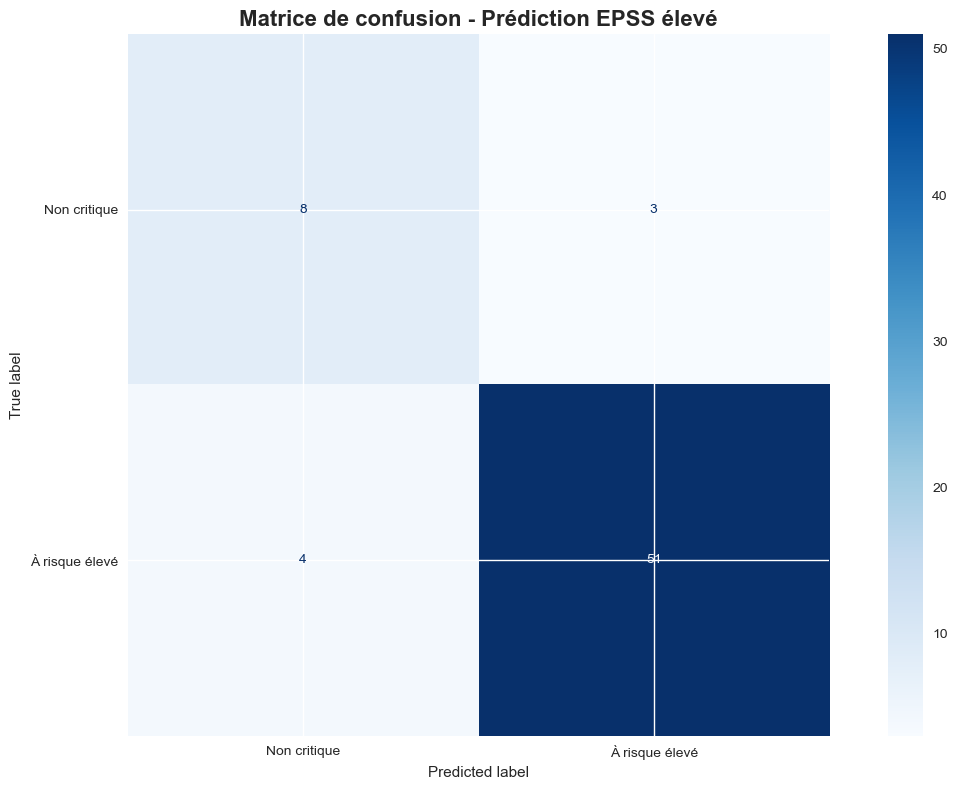

In [157]:
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=['Non critique', 'À risque élevé'], cmap='Blues')
plt.title("Matrice de confusion - Prédiction EPSS élevé", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Visualisation de la courbe ROC-AUC

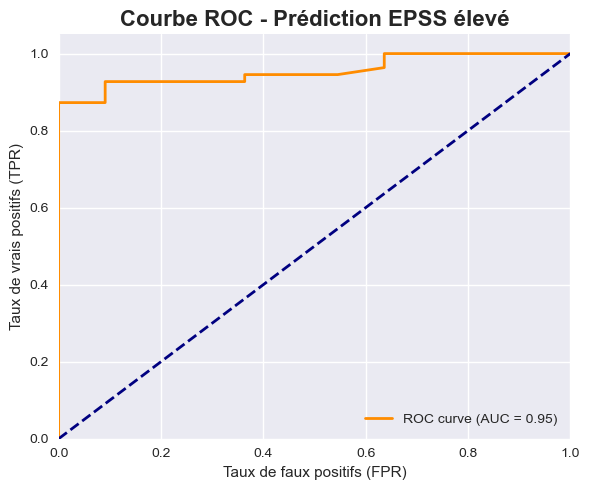

In [158]:
# Prédictions probabilistes pour la classe positive
y_probs = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC - Prédiction EPSS élevé', fontsize=16, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

### Visualisation de l'importance des features

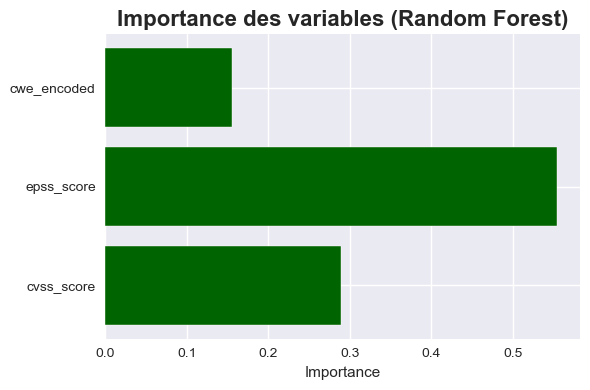

In [159]:
feature_names = features.columns
feature_importance = clf.feature_importances_
plt.figure(figsize=(6, 4))
plt.barh(feature_names, feature_importance, color='darkgreen')
plt.xlabel("Importance")
plt.title("Importance des variables (Random Forest)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Modèle non supervisé : KMeans sur CVSS et EPSS
Objectif : regrouper les vulnérabilités dans 4 clusters différents en fonction de leurs scores EPSS et CVSS

In [160]:
# Preparation des features (scores CVSS et EPSS
unsupervised_features = ml_df[['cvss_score', 'epss_score']]

# Normalisation de la matrice de features
X_unsup_scaled = scaler.fit_transform(unsupervised_features)

# Création du modèle KMeans avec 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_unsup_scaled)
ml_df['cluster'] = kmeans.labels_
print(ml_df.head())

# Sauvegarde du DataFrame avec clustering
ml_df.to_csv("data/final_cve_data_clustered.csv", index=False)
df.to_csv("data/final_cve_data_clustered.csv", index=False)

                     id                                              title  \
0  CERTFR-2025-AVI-0392  Multiples vulnérabilités dans Mattermost Serve...   
1  CERTFR-2025-AVI-0392  Multiples vulnérabilités dans Mattermost Serve...   
2  CERTFR-2025-AVI-0396  Multiples vulnérabilités dans les produits SAP...   
3  CERTFR-2025-AVI-0396  Multiples vulnérabilités dans les produits SAP...   
4  CERTFR-2025-AVI-0396  Multiples vulnérabilités dans les produits SAP...   

   type       date          cve_id  cvss_score base_severity type_cwe  \
0  Avis 2025-05-13   CVE-2025-4128         3.1           LOW  CWE-863   
1  Avis 2025-05-13   CVE-2025-4573         4.1        MEDIUM   CWE-90   
2  Avis 2025-05-13  CVE-2025-43003         6.4        MEDIUM  CWE-749   
3  Avis 2025-05-13  CVE-2025-43007         6.3        MEDIUM  CWE-862   
4  Avis 2025-05-13  CVE-2025-23191         3.1           LOW  CWE-644   

   epss_score                                               link  \
0     0.00023  https://w

### Visualisation des clusters KMeans avec centres (croix rouges)

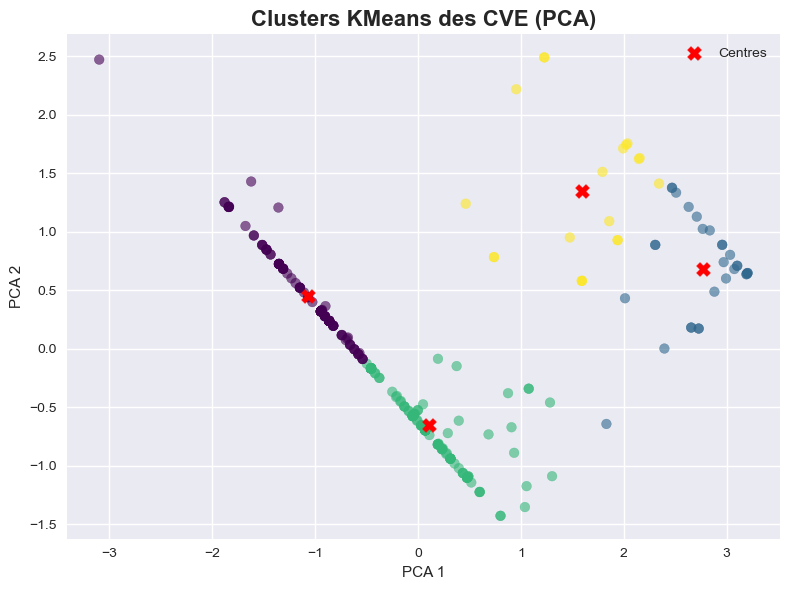


Résumé statistique par cluster (CVSS et EPSS):
        cvss_score                 epss_score                
              mean       std count       mean       std count
cluster                                                      
0         4.986992  0.950406   123   0.002530  0.012333   123
1         9.423333  0.623496    30   0.860474  0.132554    30
2         7.786624  0.778896   157   0.016686  0.054099   157
3         7.150000  0.976298    20   0.753425  0.174799    20


In [161]:
# PCA pour visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_unsup_scaled)
ml_df['pca1'] = X_pca[:, 0]
ml_df['pca2'] = X_pca[:, 1]

centers = pca.transform(kmeans.cluster_centers_)
plt.figure(figsize=(8, 6))
plt.scatter(ml_df['pca1'], ml_df['pca2'], c=ml_df['cluster'], cmap='viridis', alpha=0.6)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, marker='X', label='Centres')
plt.title("Clusters KMeans des CVE (PCA)", fontsize=16, fontweight='bold')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Analyse descriptive des clusters
cluster_summary = ml_df.groupby('cluster')[['cvss_score', 'epss_score']].agg(['mean', 'std', 'count'])
print("\nRésumé statistique par cluster (CVSS et EPSS):")
print(cluster_summary)